# Импорты

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter('ignore')

# Данные

In [2]:
df = pd.read_csv('skab_valve_1.csv', sep = ';', parse_dates=['datetime'])
df

,datetime,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
0,2020-03-09 12:34:37,0.028030,0.040400,1.182850,0.054711,69.9219,24.9122,229.918,32.9875,0.0,0.0
1,2020-03-09 12:34:38,0.026952,0.038880,1.452680,-0.273216,69.9147,24.9038,219.566,32.0129,0.0,0.0
2,2020-03-09 12:34:39,0.027958,0.040660,1.023000,0.054711,69.8861,24.9055,237.717,32.9875,0.0,0.0
3,2020-03-09 12:34:40,0.027277,0.040736,1.227510,-0.273216,69.8397,24.9110,227.621,32.0000,0.0,0.0
4,2020-03-09 12:34:41,0.027210,0.039489,1.215260,-0.273216,69.9136,24.9110,221.634,32.0129,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1089,2020-03-09 12:54:33,0.027358,0.041076,0.646547,0.054711,70.1018,24.8565,241.861,32.0000,0.0,0.0
1090,2020-03-09 12:54:34,0.027187,0.039463,0.672100,0.382638,70.0783,24.8596,246.590,32.0000,0.0,0.0
1091,2020-03-09 12:54:35,0.027795,0.040085,0.596467,0.054711,70.0489,24.8600,232.107,32.0000,0.0,0.0
1092,2020-03-09 12:54:36,0.026888,0.039586,0.914037,0.382638,70.1022,24.8553,253.688,31.0151,0.0,0.0


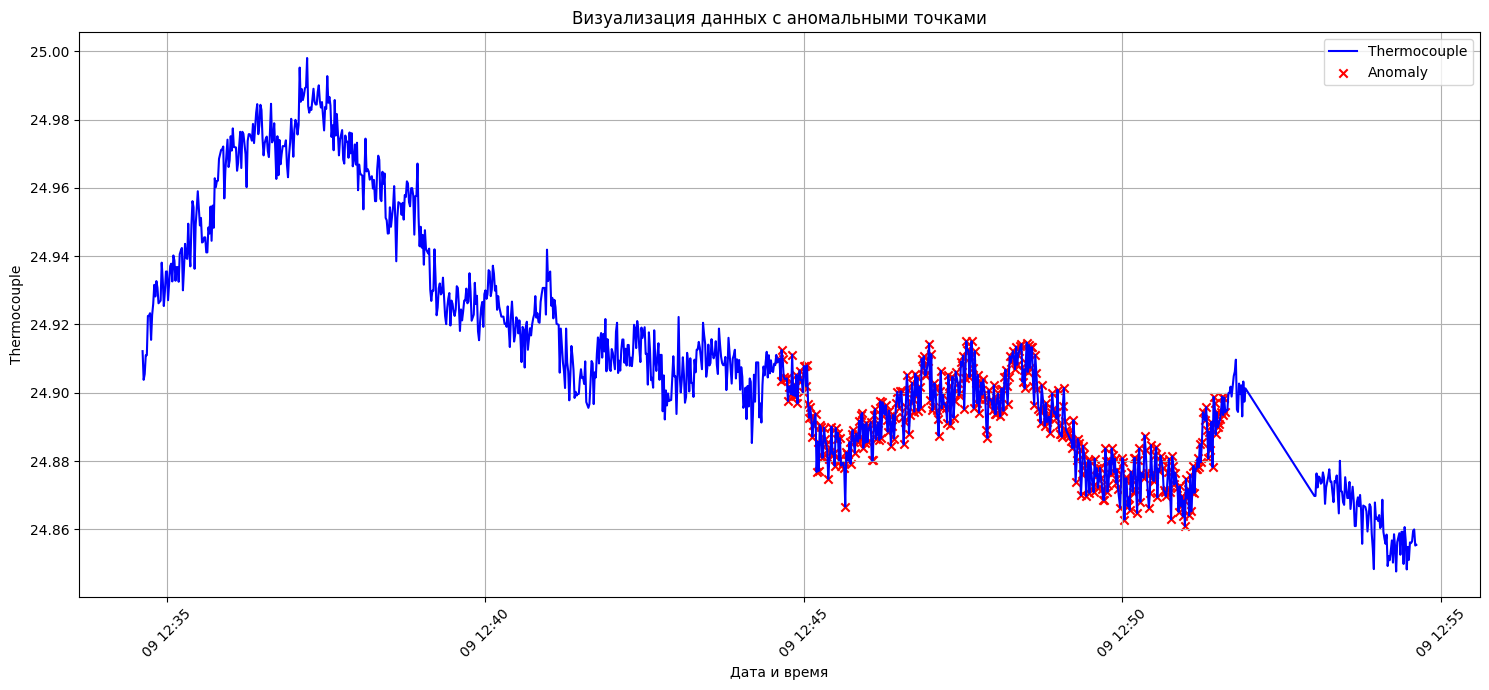

In [3]:
# Визуализация
plt.figure(figsize=(15, 7))
plt.plot(df['datetime'], df['Thermocouple'], label='Thermocouple', color='blue')

anomalies = df[df['anomaly'] == 1.0] # Пометим аномальные точки
plt.scatter(anomalies['datetime'], anomalies['Thermocouple'], color='red', label='Anomaly', marker='x')

# подписи и легенда
plt.title('Визуализация данных с аномальными точками')
plt.xlabel('Дата и время')
plt.ylabel('Thermocouple')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()

# Поиск аномалий

## Статистические эвристики

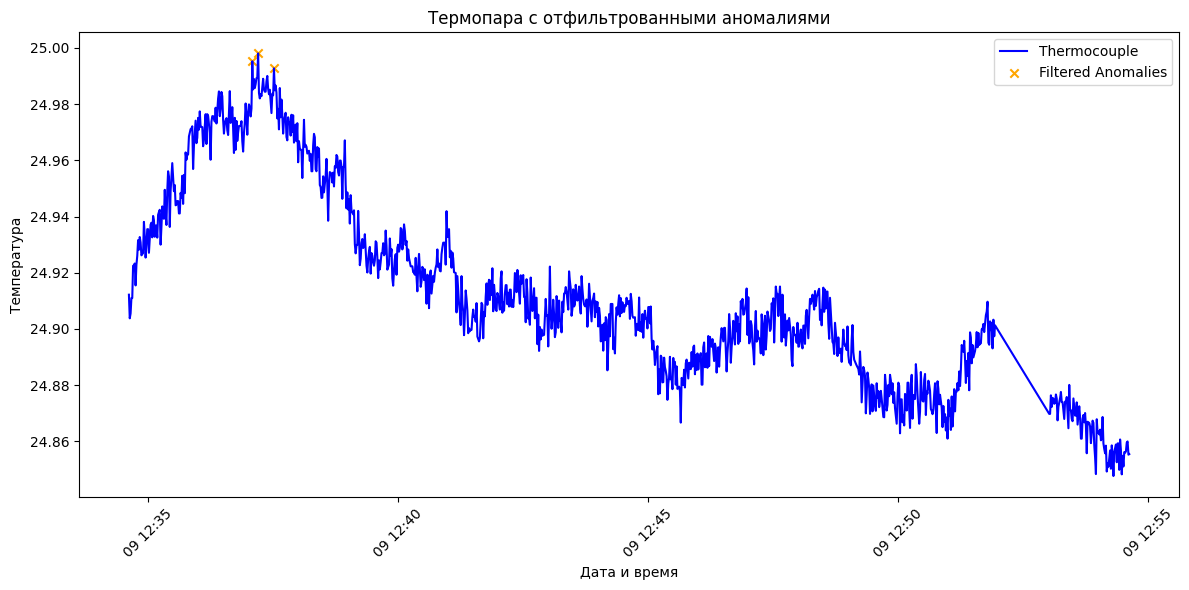

In [4]:
# фильтрация аномалий
Q1 = df['Thermocouple'].quantile(0.25)
Q3 = df['Thermocouple'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['Thermocouple'] < lower_bound) | (df['Thermocouple'] > upper_bound)]

# Визуализация аномалий
plt.figure(figsize=(12, 6))
plt.plot(df['datetime'], df['Thermocouple'], label='Thermocouple', color='blue')
plt.scatter(outliers['datetime'], outliers['Thermocouple'], color='orange', label='Filtered Anomalies', marker='x')
plt.title('Термопара с отфильтрованными аномалиями')
plt.xlabel('Дата и время')
plt.ylabel('Температура')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [5]:
predictions = [1 if val in outliers['Thermocouple'].values else 0 for val in df['Thermocouple']]

cm_stat = confusion_matrix(df['anomaly'], predictions)
print("Confusion Matrix:")
print(cm_stat)

Confusion Matrix:
[[686   3]
 [405   0]]


Из графика видно, что полученные значения аномалий неверны.

Из матрицы ошибок понятно, что полученные с помощью модели значения являются False Positive, т.е. не аномальные точки, неправильно определенных как аномальные.


## Кластеризация

In [6]:
df_sec = df.set_index('datetime').resample('S').mean().reset_index()
df_sec.head()

,datetime,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
0,2020-03-09 12:34:37,0.028030,0.040400,1.18285,0.054711,69.9219,24.9122,229.918,32.9875,0.0,0.0
1,2020-03-09 12:34:38,0.026952,0.038880,1.45268,-0.273216,69.9147,24.9038,219.566,32.0129,0.0,0.0
2,2020-03-09 12:34:39,0.027958,0.040660,1.02300,0.054711,69.8861,24.9055,237.717,32.9875,0.0,0.0
3,2020-03-09 12:34:40,0.027277,0.040736,1.22751,-0.273216,69.8397,24.9110,227.621,32.0000,0.0,0.0
4,2020-03-09 12:34:41,0.027210,0.039489,1.21526,-0.273216,69.9136,24.9110,221.634,32.0129,0.0,0.0


In [7]:
# Feature-Engineering для создания признаков
for df in [df_sec]:
    df['Second'] = df['datetime'].dt.second
    df['Lag'] = df['Thermocouple'].shift(1)
    df['Rolling_Mean'] = df['Thermocouple'].rolling(7, min_periods=1).mean()
    df = df.dropna()

С помощью метода локтя определим нужное количество кластеров. Получаем значение 4

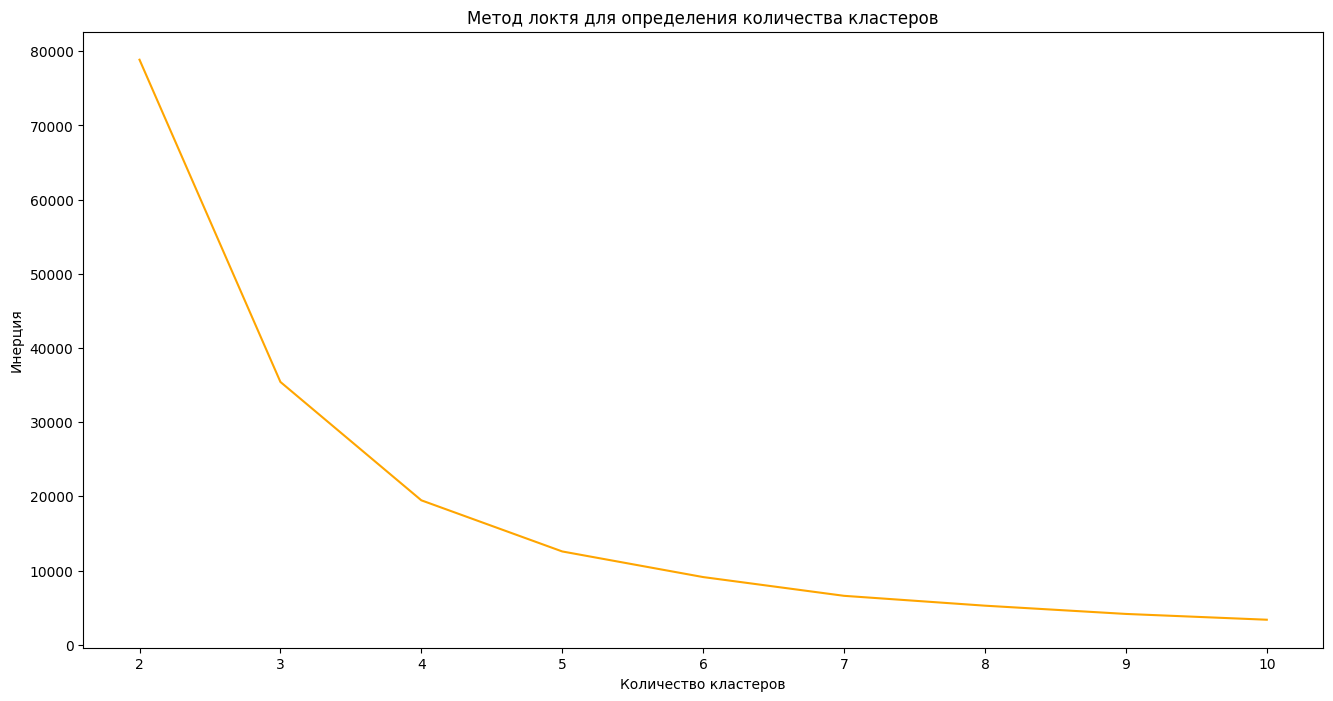

In [8]:
# Выбор столбцов для кластеризации
cols = df[['Thermocouple', 'Lag', 'Rolling_Mean', 'Second']]
n_cluster = range(2, 11)

kmeans = [KMeans(n_clusters=i).fit(cols) for i in n_cluster]
scores = [kmeans[i].inertia_ for i in range(len(kmeans))]

# Вывод результатов
fig, ax = plt.subplots(figsize = (16, 8))
ax.plot(n_cluster, scores, color = 'orange')

plt.xlabel('Количество кластеров')
plt.ylabel('Инерция')
plt.title('Метод локтя для определения количества кластеров')
plt.show();

In [9]:
scaler = StandardScaler() # Стандартизация данных
scaled_features = scaler.fit_transform(cols)

kmeans = KMeans(n_clusters=4, random_state=42).fit(scaled_features)
df['cluster'] = kmeans.labels_

most_common_cluster = df['cluster'].mode()[0] # Фильтрация аномалий
df['is_anomaly'] = df['cluster'] != most_common_cluster

In [10]:
df['is_anomaly']

,is_anomaly
1,False
2,True
3,True
4,True
5,False
...,...
1196,True
1197,True
1198,True
1199,True


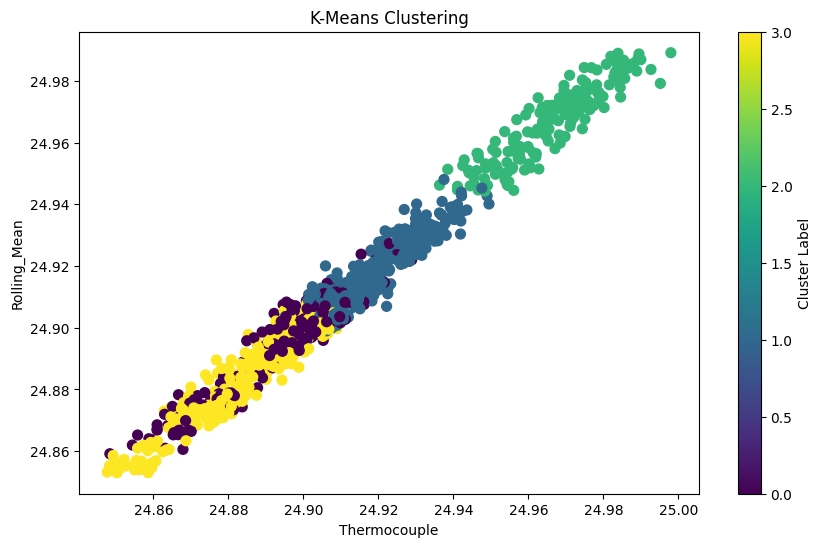

In [11]:
# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.scatter(df['Thermocouple'], df['Rolling_Mean'], c=df['cluster'], cmap='viridis', s=50)
plt.title('K-Means Clustering')
plt.xlabel('Thermocouple')
plt.ylabel('Rolling_Mean')
plt.colorbar(label='Cluster Label')
plt.show()

In [12]:
cm_class = confusion_matrix(df['anomaly'], df['is_anomaly']) # матрица ошибок
print("Confusion Matrix:")
print(cm_class)

Confusion Matrix:
[[258 402]
 [ 40 349]]


Если брать за аномалии наименее распространенный кластер(в нашем случае фиолетовый), то данная модель неверно определила аномалии.

Также изучив матрицу ошибок можно увидеть что она определила 402 значения False Positive и 349 значений True Positive, из чего также можно сделать вывод что модель плохо справилась с задачей определения аномалий.

## Isolation Forest


In [13]:
X = df[['Thermocouple', 'Lag', 'Rolling_Mean']]
y = df['anomaly']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [14]:
clf = IsolationForest(max_samples=100, random_state=42)
clf.fit(X_train)

IsolationForest(max_samples=100, random_state=42)

In [15]:
y_pred = clf.fit_predict(X_test)

# Преобразуем предсказания: 1 - нормальное значение, -1 - аномалия
y_pred = np.where(y_pred == 1, 0, 1)

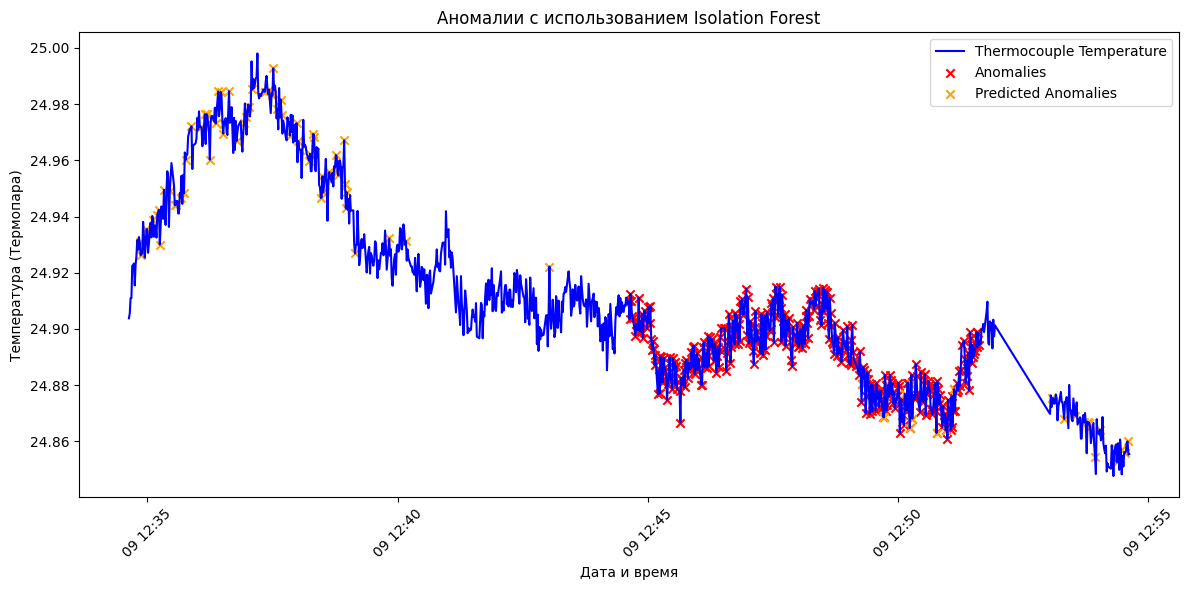

In [16]:
# Визуализация предсказаний
plt.figure(figsize=(12, 6))
plt.plot(df['datetime'], df['Thermocouple'], label='Thermocouple Temperature', color='blue')
anomalies_if = df[df['anomaly'] == 1]
plt.scatter(anomalies_if['datetime'], anomalies_if['Thermocouple'], color='red', label='Anomalies', marker='x')

# Отметим предсказанные аномалии
predicted_anomalies = df.loc[X_test.index]
predicted_anomalies['predicted_anomaly'] = y_pred
anomalies_predicted = predicted_anomalies[predicted_anomalies['predicted_anomaly'] == 1]
plt.scatter(anomalies_predicted['datetime'], anomalies_predicted['Thermocouple'],
            color='orange', label='Predicted Anomalies', marker='x')

plt.title('Аномалии с использованием Isolation Forest')
plt.xlabel('Дата и время')
plt.ylabel('Температура (Термопара)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
# Вычисляем матрицу ошибок
cm_if = confusion_matrix(y_test, y_pred)
print(cm_if)

[[89 76]
 [86 12]]


На графике видно что модель Isolation Forest плохо справилась с обнаружением аномалий.

Из матрицы ошибок мы видим что модель правильно(True Positive) отметила только 12 значений и неверно отметила как аномалии(False Positive) 76 значений.



# Результаты по всем экспериментам

In [18]:
# Преобразуем матрицы ошибок в DataFrame с колонками TN, FP, FN, TP
def cm_to_df(cm, model_name):
    TN, FP, FN, TP = cm.ravel()
    return pd.DataFrame({
        'Model': [model_name],
        'TN': [TN],
        'FP': [FP],
        'FN': [FN],
        'TP': [TP]
    })

cm_if_df = cm_to_df(cm_if, 'Isolation Forest')
cm_class_df = cm_to_df(cm_class, 'Clustering')
cm_stat_df = cm_to_df(cm_stat, 'Statistical')

# Объединяем все данные в один DataFrame
results = pd.concat([cm_if_df, cm_class_df, cm_stat_df], ignore_index=True)

In [20]:
results

,Model,TN,FP,FN,TP
0,Isolation Forest,89,76,86,12
1,Clustering,258,402,40,349
2,Statistical,686,3,405,0
